# "A Simple and Reliable Way to Compute Option-Based Risk-Neutral Distributions"

## https://www.newyorkfed.org/medialibrary/media/research/staff_reports/sr677.pdf

Implementing the methodology described for exchange traded products

---

## Import external libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

## Example volatility data (page 13 of paper)

In [2]:
lst = [
    [80.0, 23.95],
    [90.0, 21.71],
    [95.0, 18.81],
    [97.5, 17.40],
    [100.0, 16.09],
    [102.5, 14.88],
    [105.0, 13.84],
    [110.0, 12.48],
    [120.0, 12.34],
]

df = pd.DataFrame(lst, columns=['moneyness', 'implied_vol']).set_index('moneyness')
K_range = np.linspace(70, 130, 100) # strike range for interpolation

## Intialising clamped CubicSpline function

clamped_cubic is a wrapper on CubicSpline in order to allow for flat extrapolation beyond the two end knots.

In [13]:
f = CubicSpline(df.index, df['implied_vol'], bc_type='clamped')

def clamped_cubic(X, boundary=(None, None)):
    """
    Adjusts scipy's CubicSpline method to provide flat extrapolation.
    
    Parameters
    ----------
    X = list of interpolation points
    boundary = tuple of lower and upper values for flat extrapolation
    """
    
    lower, upper = boundary
    f = CubicSpline(df.index, df['implied_vol'], bc_type='clamped')
    bounded_func = lambda x: f(lower) if x < lower else (f(upper) if x > upper else f(x)) 
    
    return [bounded_func(x) for x in X]

## Plot interpolated / extrapolated volatility smile

Wall time: 78.2 ms


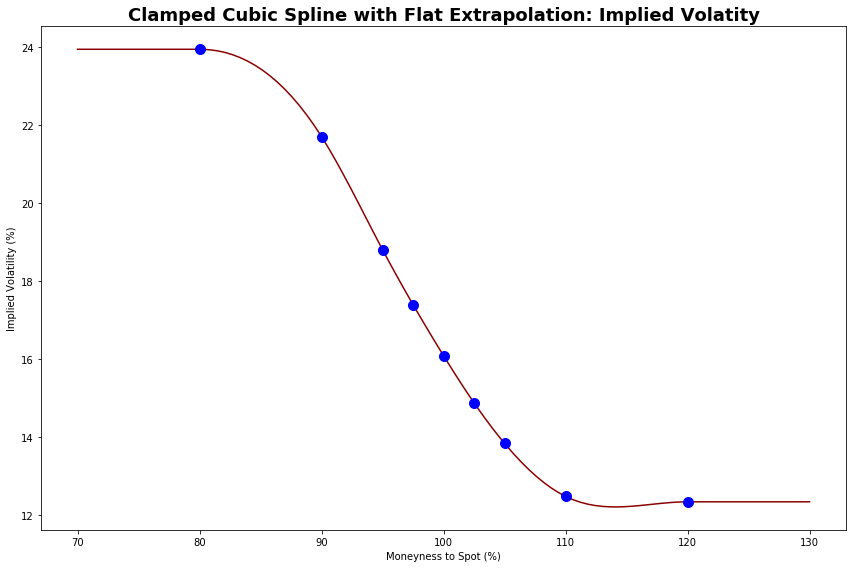

In [14]:
%%time
plt.figure(figsize=(12, 8))
plt.plot(K_range, clamped_cubic(K_range, boundary=(df.index[0], df.index[-1])), color='darkred', label='spline')
plt.plot(df.index, df['implied_vol'], color='b', marker='o', linestyle="", markersize=10)
plt.title('Clamped Cubic Spline with Flat Extrapolation: Implied Volatity', fontweight='bold', fontsize='18')
plt.ylabel('Implied Volatility (%)')
plt.xlabel('Moneyness to Spot (%)')
plt.tight_layout();

## Implementation of Black-Scholes European Call pricing function

In [5]:
def bs_call(K, T, r, d, v):
    """
    Black-Scholes Call Price.
    
    Parameters:
    K = strike moneyness percent (80% = 80)
    T = years to maturity
    r = annualised continuously compounded risk-free rate with tenor T
    d = annualised continuously compounded dividend yield over tenot T
    v = implied volatility
    """
    
    S=100
    d1 = (np.log(float(S) / K)+((r - d)+v * v / 2.)*T)/(v * np.sqrt(T))
    d2 = d1 - v * np.sqrt(T)
    
    return S * np.exp(-d * T)*norm.cdf(d1)-K * np.exp(-r * T) * norm.cdf(d2)

## Example parameters to create call prices from volatily smile

In [56]:
T = 0.25
r = 0.00058
d = 0.02306

# for all points across the smile
bs_call_px = [bs_call(K, T, r, d, clamped_cubic([K], boundary=(df.index[0], df.index[-1]))[0]/100) for K in K_range]

# converting volatility knots to price knots
bs_call_knots = [bs_call(K, T, r, d, v/100) for K, v in df.itertuples()]

## Plot interpolated / extrapolated call price smile

Wall time: 68.2 ms


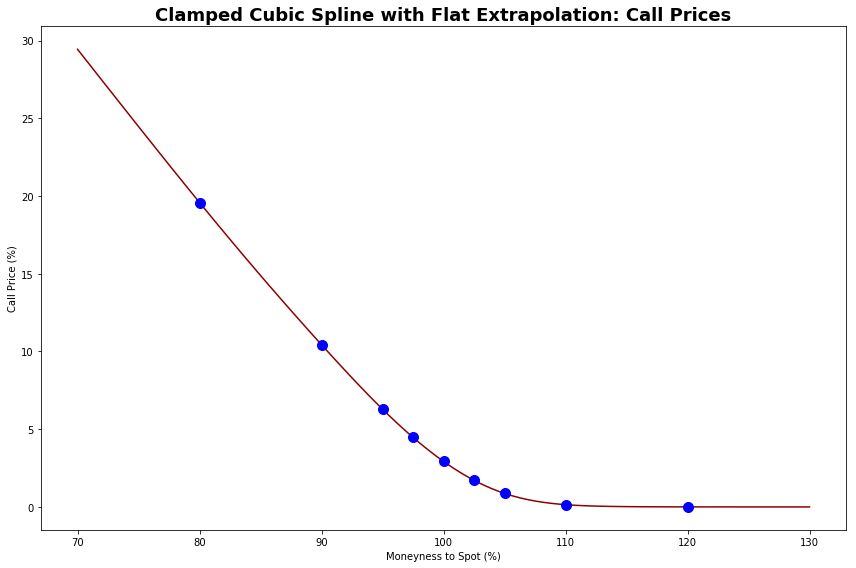

In [57]:
%%time
plt.figure(figsize=(12, 8))
plt.plot(K_range, bs_call_px, color='darkred', label='spline')
plt.plot(df.index, bs_call_knots, color='b', marker='o', linestyle="", markersize=10)
plt.title('Clamped Cubic Spline with Flat Extrapolation: Call Prices', fontweight='bold', fontsize='18')
plt.ylabel('Call Price (%)')
plt.xlabel('Moneyness to Spot (%)')
plt.tight_layout();

## Create method to calculated implied CDF function

"In the absence of arbitrage, the mathematical derivative of call option value with respect to excercise price is closely related to the risk-neutral probability that the future asset price will be no higher than the exercise price at option maturity."
Breeden and Litzenberger (1978)

Based on the above, the future value call strike delta plus one will approximately equal the Option-Based Cumulative Density Function (CDF).

In [59]:
def option_CDF(K, T, r, d, e=1):
    """
    Option-Based CDF function.
    
    Parameters:
    K = strike moneyness percent (80% = 80)
    T = years to maturity
    r = annualised continuously compounded risk-free rate with tenor T
    d = annualised continuously compounded dividend yield over tenot T
    e = epsilon for discrete derivative approximation
    """
    
    uK = K + e/2
    dK = K - e/2
    
    uv = clamped_cubic([uK], boundary=(df.index[0], df.index[-1]))[0]
    dv = clamped_cubic([dK], boundary=(df.index[0], df.index[-1]))[0]
    
    u_call_px, d_call_px = bs_call(uK, T, r, d, uv/100), bs_call(dK, T, r, d, dv/100)
    
    return 1 + np.exp(r*T) * (u_call_px - d_call_px) / e

## Generate Option-Based CDF and Plot

Wall time: 138 ms


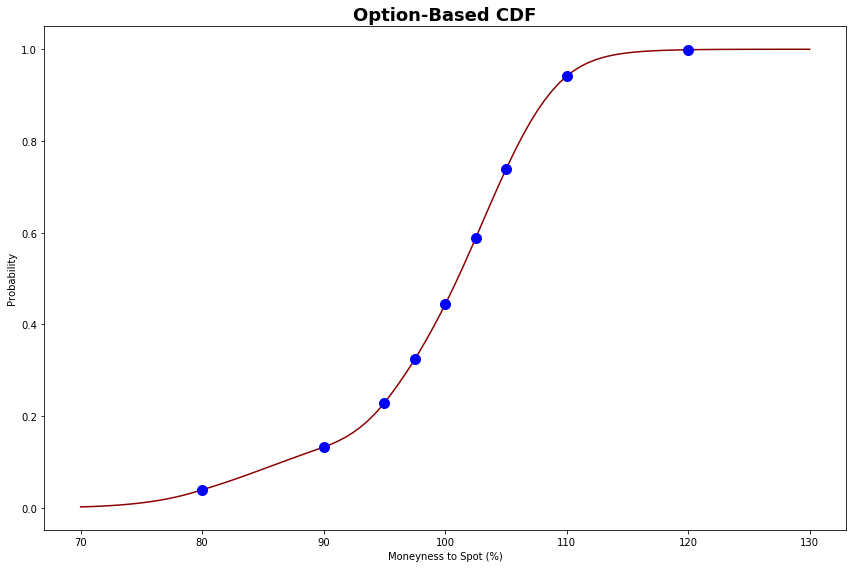

In [23]:
%%time
cdf = [option_CDF(K, T, r, d) for K in K_range]
cdf_knots = [option_CDF(K, T, r, d) for K in df.index]
    
plt.figure(figsize=(12, 8))
plt.plot(K_range, cdf, color='darkred', label='spline')
plt.plot(df.index, cdf_knots, color='b', marker='o', linestyle="", markersize=10)
plt.title('Option-Based CDF', fontweight='bold', fontsize='18')
plt.ylabel('Probability')
plt.xlabel('Moneyness to Spot (%)')
plt.tight_layout();

## Create method to calculated implied PDF function

If the CDF is equivelent to the 

In [19]:
def option_PDF(K, T, r, d, e=1):
    """
    Option-Based PDF function.
    
    Parameters:
    K = strike moneyness percent (80% = 80)
    T = years to maturity
    r = annualised continuously compounded risk-free rate with tenor T
    d = annualised continuously compounded dividend yield over tenot T
    e = epsilon for discrete derivative approximation
    """
    
    uK = K + e/2
    dK = K - e/2
    
    u_cdf, d_cdf = option_CDF(uK, T, r, d, e), option_CDF(dK, T, r, d, e)
    
    return np.exp(r*T) * (u_cdf - d_cdf) / e

## Generate Option-Based PDF and Plot

Wall time: 209 ms


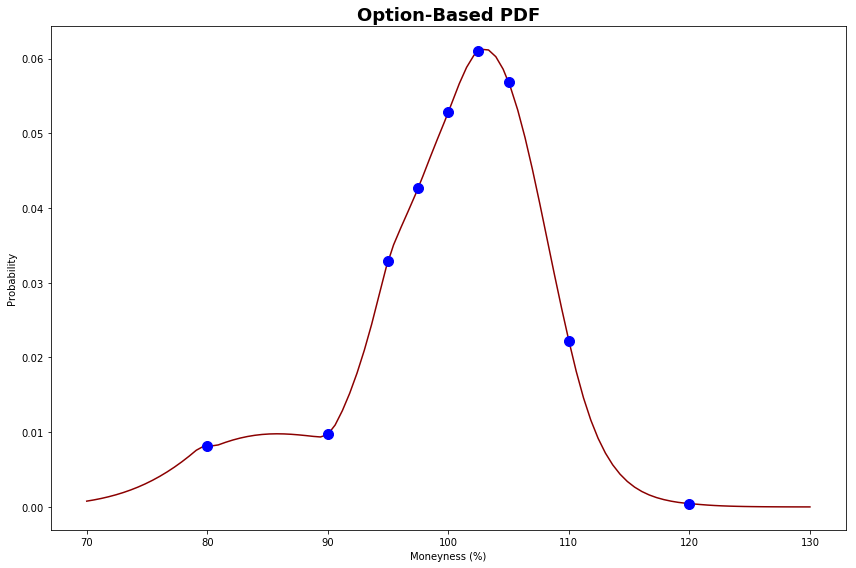

In [24]:
%%time
pdf = [option_PDF(K, T, r, d) for K in K_range]
pdf_points = [option_PDF(K, T, r, d) for K in df.index]
    
plt.figure(figsize=(12, 8))
plt.plot(K_range, pdf, color='darkred', label='spline')
plt.plot(df.index, pdf_points, color='b', marker='o', linestyle="", markersize=10)
plt.title('Option-Based PDF', fontweight='bold', fontsize='18')
plt.ylabel('Probability')
plt.xlabel('Moneyness (%)')
plt.tight_layout();